## Preamble

In [1]:
import logging
import pickle
import random
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import cm
from mud.base import DensityProblem, BayesProblem, SpatioTemporalProblem
from mud.examples import polynomial_1D, random_linear_problem, random_linear_wme_problem
from mud.plot import *
from mud.util import rank_decomposition  # , std_from_equipment
from scipy.stats import norm

__author__ = "Carlos del-Castillo-Negrete"
__copyright__ = "Carlos del-Castillo-Negrete"
__license__ = "mit"

# Matplotlib plotting options
plt.backend = "Agg"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.size"] = 16
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{bm}"
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsfonts}"

params = {
    "axes.labelsize": 6,
    "axes.titlesize": 6,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "axes.titlepad": 1,
    "axes.labelpad": 1,
    "font.size": 12,
}
plt.rcParams.update(params)

_logger = logging.getLogger(__name__)

figs = {}

In [2]:
%matplotlib widget

save_figs = False

<a id='Title'></a>
# <center> Parameter Identification with Maximal Updated Densities: Existence, Uniqueness, and Convergence
_____


<center>
    Michael Pilosov, Carlos del-Castillo-Negrete, Tian Yu Yen, Troy Butler, Clint Dawson
    <br>
</center>
    
<center>
    Notebook by:
    <br>
    Carlos del-Castillo-Negrete (<font color='blue'>cdelcastillo21@gmail.com</font>)
</center>


# Comparing Inverse Problems and Solution

This notebook is in ended to supplement [ref] section 2 covering differences in problem formulation and solutions between Bayesian and Data-Consistent Inversion. 
:set number


<a id='Title'></a>
## Comapring Solutions Solutions
---


* Data-Consistent: 

    $\Large \pi_{up}(\lambda) = \pi_{in}(\lambda)\frac{\pi_{ob}(Q(\lambda))}{\pi_{pred}(Q(\lambda))}$

* Bayesian:

    $\Large \pi_{post}(\lambda | d) = \frac{\pi_{prior}(\lambda)\pi_{like}(d | \lambda)}{\int_{\Lambda}\pi_{prior}(\lambda)\pi_{like}(d | \lambda)}$


Note:

* Prior density $\pi_{prior}$ represents an initial description of the epistemic, or reducible, uncertainty on $\Lambda$ in the Bayesian framework, while $\pi_{in}$ represents initial descripton of aleatoric, or irreducible, uncertainty on $\Lambda$.

* Form for Bayesian comes from Bayes rule [ref] while form for Data-Consistent comes from Disintegration theorem and Bayes rule [ref].

* The data-likelihood in the Bayesian framework, $\pi_{like}(d | \lambda)$, plays a role in the normalizing constant of the Bayesian solution, while the observed density $\pi_{ob}(Q(\lambda))$ does not in the Data-Consistent framework. 


## Example 1 - Low Dimensional Example
---

We start with a simple QoI map over a one-dimensional parameter space:
   
   $$ \Large \Lambda = [-1, 1] \in \mathbb{R} $$  
   
   $$ \Large Q(\lambda) = \lambda^5 \rightarrow \mathcal{D} = [-1, 1] $$

We will frame the Data-Consistent and Bayesian inverse problems for this particular case as similarily as possilbe, to show that even when we do so the two frameworks solve fundamentally different inverse problems.

### Data

We take $N$ samples from an initial uniform distribution over the input parameter space. These samples will be pushed forward through our QoI map to constrcut the data likelihood $\pi_{like}$ for the Bayesian framework and the predicted density $\pi_{pred}$ for the Data-Consistent Framework. 

In [26]:
seed = 123456

# Number of samples to use, and assumed observed normal distribution parameters
p, n_samples, mu, sigma, domain = 5, int(1e3), 0.25, 0.1, np.array([[-1, 1]])
lam, q_lam, data = polynomial_1D(
    p=p, n_samples=n_samples, domain=domain, mu=mu, sigma=sigma, N=1
)

### Data Consistent Approach

For the Data-Consistent framework we assume:

   $\pi_{in} \sim \mathcal{U}([-1, 1])$
  
   $\pi_{ob} \sim \mathcal{N}(0.25,0.1^2)$

In [27]:
# Construct density problem object using lambda samples and QoI Values
# Note by default DensityProblem class assumes uniform distribution over domain if nothing specified
# The predicted distribution will be determined from a Gaussian Kernel Density Estimate over predicted values
# Have to set observed distribution -> assuming known sample mean, 0.25, and std dev, 0.1, from observed data.
d_prob = DensityProblem(lam, q_lam, domain=domain)
d_prob.set_observed(norm(loc=mu, scale=sigma))

# Get Maximal Updated Density (MUD) point estimate
d_prob.estimate()

array([0.78289324])

### Bayesian Approach

Bayesian - Epistemic Uncertainty - Assumptions:

   For all $d \in \mathcal{D}, d = Q(\lambda^\dagger) + \xi, \xi \sim N (0,0.1^2)$
   
   $\pi_{prior} \sim \mathcal{U}([-1, 1])$
   
   Build $\pi_{post}(d | \lambda)$ assuming observed value of $d = 0.25$, leading to likelihood that matches observed distribution $N(0.25, 0.1^2)$.

In [35]:
# Construct bayesian problem object using lambda samples and QoI Values
# Fit using observed data to construct data-likelihood
bayes = BayesProblem(lam, q_lam, domain=domain)
bayes.set_likelihood(norm(loc=mu, scale=sigma))
bayes.estimate()

array([0.75833904])

### Comparison Plots

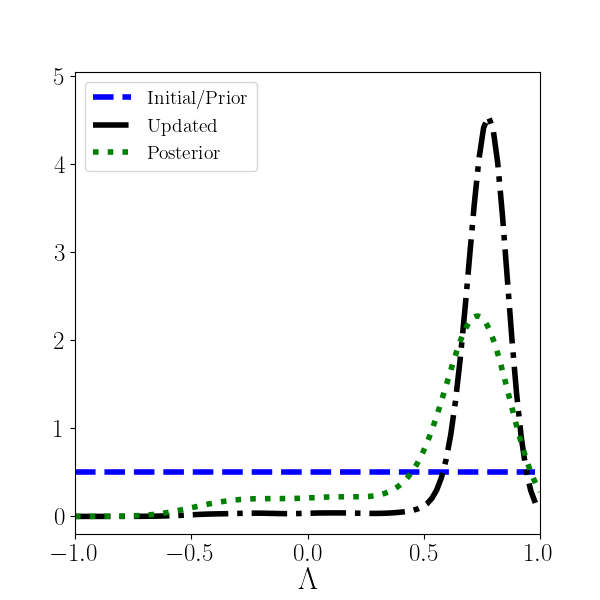

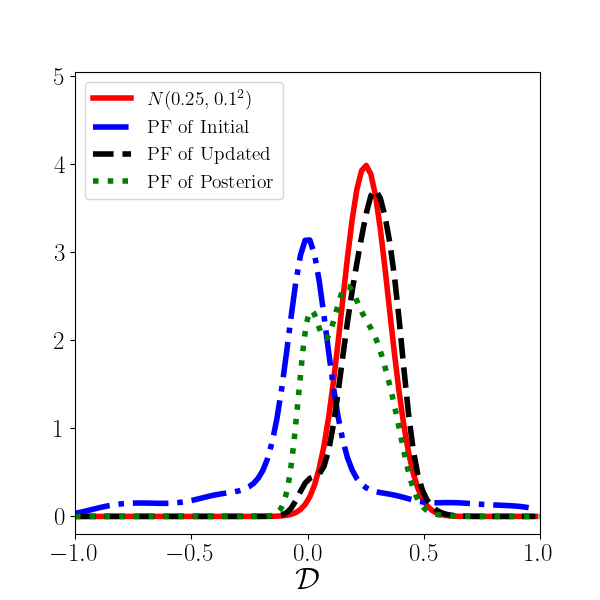

In [4]:
plt.close("all")
_ = run_comparison_example(N_vals=[1], plot_version=1, save_path=None, close_fig=False)

# Data-Constructed QoI Maps 1: The Repeated Measurements Case

This notebook is intended to supplement [ref] section 5 where data-constructed Quantity of Interest (QoI) Maps are explored.

## Notation and Illustrative Example

Assuming $d$ measurement devices for which repeated noisy data are obtained, let:

* $\mathcal{M}_j(\lambda^\dagger) = $ the $j$th measurement device, for each $1\leq j\leq d$.

* $N_j = $ the number of noisy data obtained for each device.

* $d_{j,i} = $ the $i$th noisy datume from $j$th measurement device, where $1\leq i \leq N_j$. 

Assuming unbiased additive error model for the measurement noise with i.i.d. Gaussian errors, we have:
    
$d_{j,i} = \mathcal{M}_j(\lambda^\dagger) + \xi_i, \xi_i \sim N(0,\sigma_j^2), 1\leq i \leq N_j$

Returning to problem from section 2:

   $\Lambda = [-1, 1] \in \mathbb{R}$  
   
   $Q(\lambda) = \lambda^5 \rightarrow \mathcal{D} = [-1, 1]$


Before, we only talked about how predicted data pushed through a model is used to solve the Bayesian and Stochastic Inversion Problems. For the Bayesian Inversion problem, it is clear that osberved data are used to construct the data-likelihood function $\pi_{post}(\lambda|d)$. The question now becomes how do we incorporate real observed data within the SIP framework. Before, in the SIP
 
For Bayesian Problem - Data are used to construct the data-likelihood function $\pi_{post}(\lambda|d)$

For SIP - We assumed the the observed distribution, $\pi_{ob}$ came from a $\mathcal{N}(0.25,0.1^2)$ distribution. 


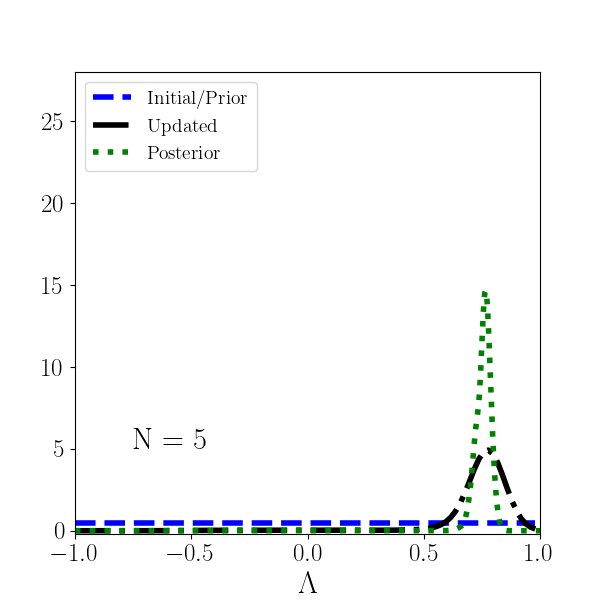

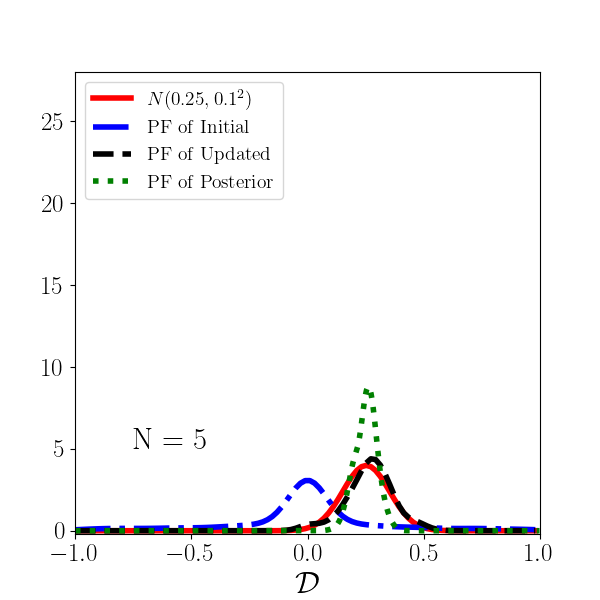

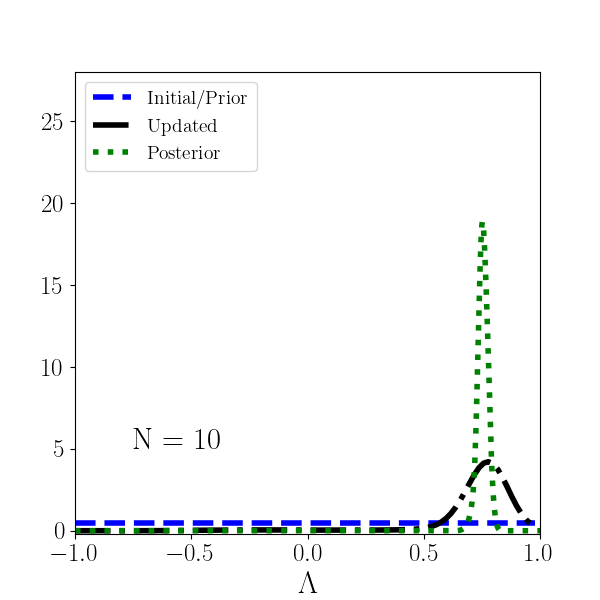

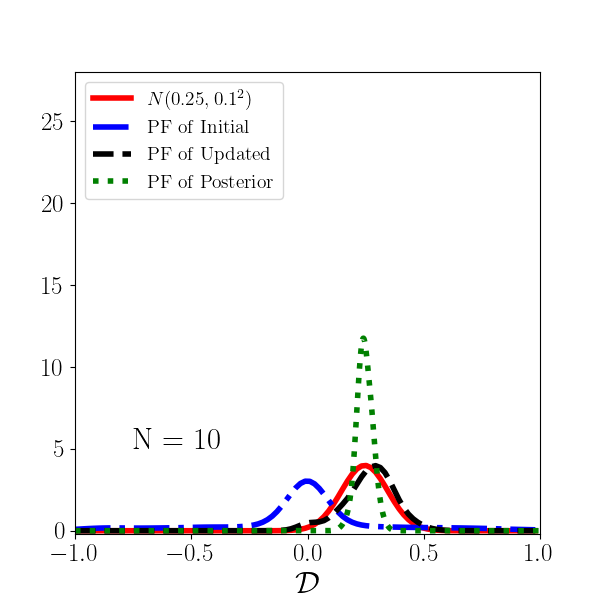

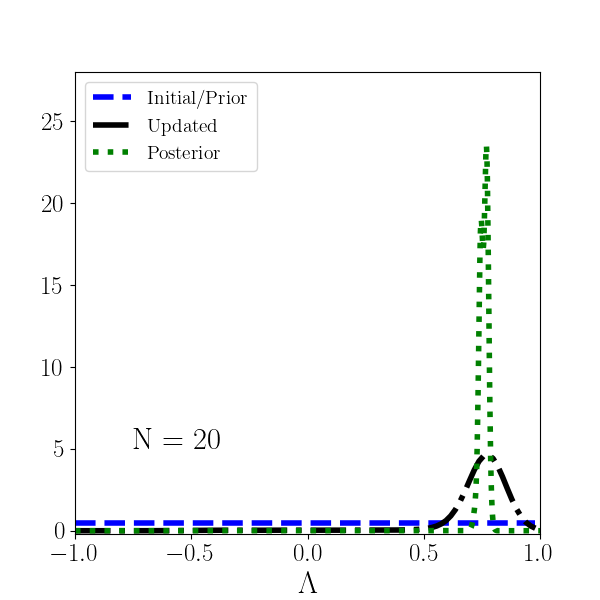

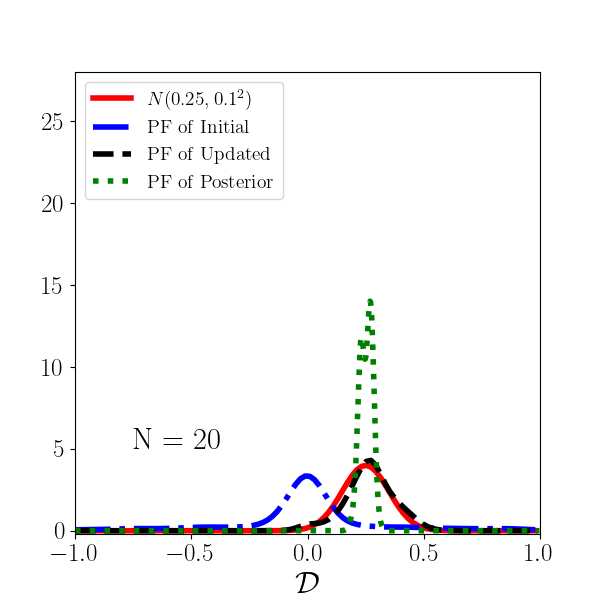

In [37]:
plt.close("all")
_ = run_comparison_example(
    N_vals=[5, 10, 20], plot_version=1, save_path=None, close_fig=False
)

## The Weighted Mean Error Map

TODO: Include motivation for Q_WME based off of statistica l sufficiency 

$ \Large Q_{WME,k}(\lambda) := \frac{1}{\sqrt{N_j}}\sum^{N_j}_{i=1}\frac{\mathcal{M}_j(\lambda) - d_{j,i}}{\sigma_j} $

## The Weighted Mean Error Map for Linear Maps

TODO: Derivation

$ \Large Q_{WME}(\lambda) = A(\mathbf{N})\lambda + b(\mathbf{N}) $ 

Where $j$th component of $\mathbf{N} \in \mathbb{R}^d$ is given by $N_j$

The $j$th row of $A(\mathbf{N})\in\mathbb{R}^{d\times p}$ by:

$ \Large A_j = \frac{1}{\sqrt{N_j}}\sum^{N_j}_{i=1}\frac{M_j}{\sigma_j} = \frac{N_j}{\sigma_j}M_j$

The $j$th component of $b(\mathbf{N})\in\mathbb{R}^d$ by:

$ \Large b_j(N) = - \frac{1}{\sqrt{N_j}}\sum^{N_j}_{i=1}\frac{d_{j,i}}{\sigma_j} $ 

# Linear Theory of MUD points


## Problem and Assumptions

In this section we assume linear (or affine) QoI maps with Gaussian distributions and compare the analytical solutions given by the Bayesian and Data-Consistent Framework:

$Q(\lambda) = A\lambda + \mathbf{b}, A \in \mathbb{R}^{d\times p}$,

For the Bayesian framework, assume 

$\pi_{prior} = \mathcal{N}(\lambda_0,\Sigma_{init}), \pi_{obs} = \mathcal{N}({\bf y}, \Sigma_{obs})$.

Our analytical MAP point is given by (eq. ref in paper):

$\lambda^{MAP} = \lambda_0 + \Sigma_{post}A^T\Sigma_{obs}^{-1}(\mathbf{y} - \mathbf{b} - A\lambda_0), 
 \Sigma_{post} := (A^T\Sigma_{obs}^{-1}A + \Sigma_{init}^{-1})^{-1}$

For the Data-Consistent framework, assume

$\pi_{in} = \mathcal{N}(\lambda_0,\Sigma_{init}), \pi_{obs} = \mathcal{N}({\bf y}, \Sigma_{obs})$.

Our analytical MUD point is given by (eq. ref in paper):

$\lambda^{MUD} = \lambda_0 + \Sigma_{init}A^T\Sigma_{pred}^{-1}(\mathbf{y} - \mathbf{b} - A\lambda_0), 
 \Sigma_{pred} := A\Sigma_{init}A^T$


## Low Dimensional Example

Problem Set-Up:

$A = \begin{bmatrix} 1 & 1 \end{bmatrix}, b = 0, y = 1$

$\lambda_0 = \begin{bmatrix} 0.25 & 0.25 \end{bmatrix}^T,
\Sigma_{init} = \begin{bmatrix} 1 & -0.25 \\ -0.25 & 0.5 \end{bmatrix},
\Sigma_{obs} = \begin{bmatrix} 0.25 \end{bmatrix}$

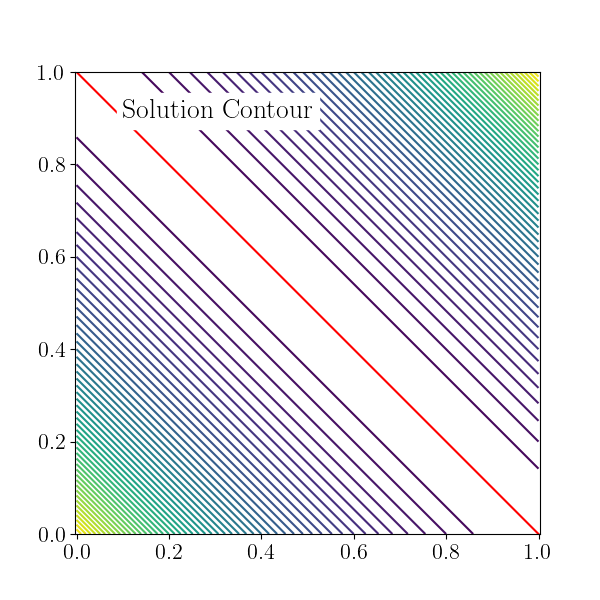

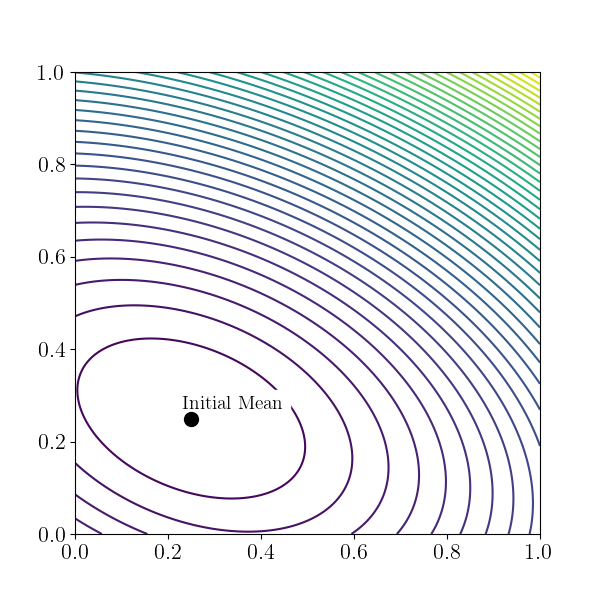

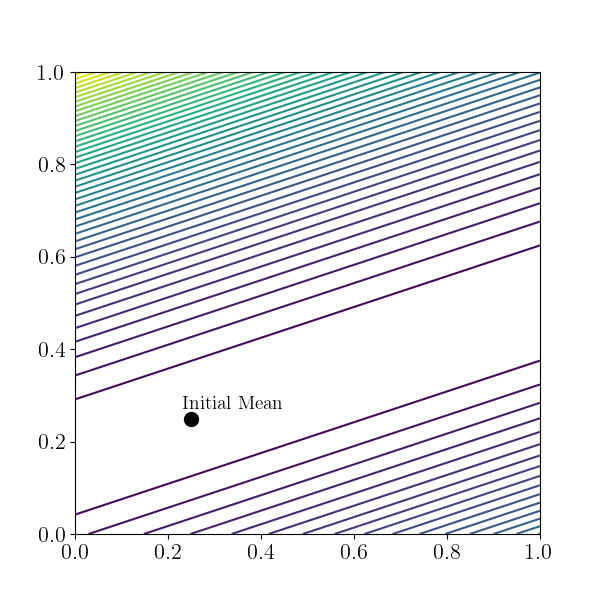

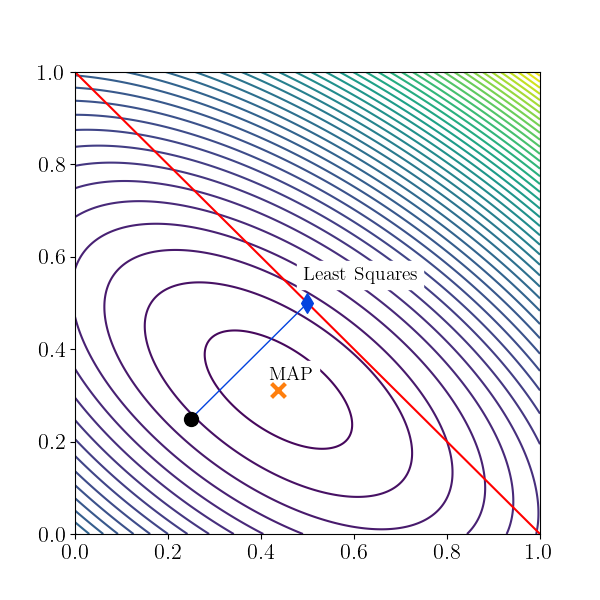

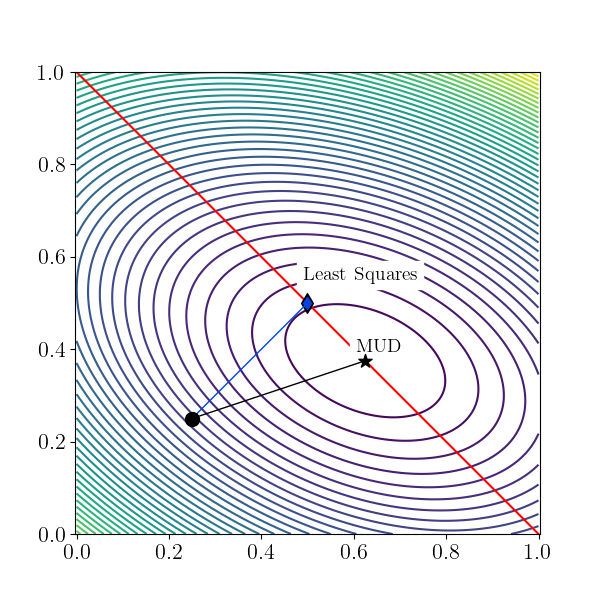

In [38]:
run_contours(close_fig=False)

### Comparing Functionals

1. Bayesian - Tikhonov regularization - Traditional solution, searching for value that minimizes residual but also without blowing up solution. 

$\Large T(\lambda) := || Q(\lambda) - \mathbf{y} || ^2_{\Sigma^{-1}_{obs}} + || \lambda-\lambda_0 || ^2_{\Sigma_{init}^{-1}}$

2. Data-Consistent - An extra term from Tikhanov reg, coming from the predicted density, to "unregularize" in drections that are informed by the data. So if large discrepancy between data and observations, term will be large.

$\Large J(\lambda) := T(\lambda) - || Q(\lambda) - Q(\lambda_0) || ^2_{\Sigma^{-1}_{pred}}$


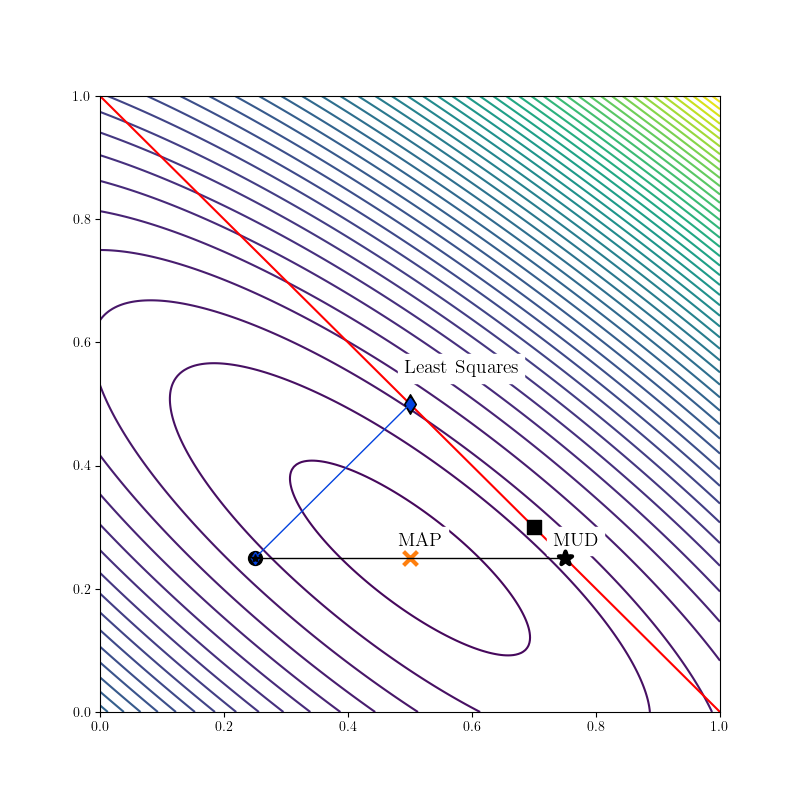

In [9]:
run_comparison_contours(close_fig=False)

## Existence and Uniqueness of MUD Points

Suppose  $Q(\lambda)=A\lambda+b$ for some full rank $A\in\mathbb{R}^{d\times p}$ with $d\leq p$ and $b\in\mathbb{R}^d$.
If $\initial \sim N(\lambda_0,\initialCov)$, $\observed\sim N(\observedMean,\observedCov)$, and the predictability assumption holds, then

1. There exists a unique parameter, denoted by $\mudpt$, that maximizes $\updated$.
2. $Q(\mudpt) = \observedMean$.
3. If $d=p$, $\mudpt$ is given by $A^{-1}$. If $d<p$, $\mudpt$ is given by~\eqref{eq:mud-point-analytical-final} and the covariance associated with this point is given by~\eqref{eq:updatedCov_final}.


If $\initial \sim N(\param_0,\initialCov)$ and data are obtained for $d$ linearly independent measurements on $\pspace$ with an additive noise model with1G i.i.d. Gaussian noise for each measurement, then
\begin{enumerate}[(a)]
\item There exists a minimum number of data points obtained for each of the measurements such that there exists a unique $\mudpt$ and $Q_\text{WME}(\mudpt) = 0$.
\item The variance in the $\mudpt$ estimate in $d$ directions of the parameter space decreases at a rate proportional to the number of data points used for each of the measurements.

## Spectral Properties of Updtaed Covariance for WME Map

We illustrate the result in the above corollary with an example that highlights how the number of distinct measurements used to form $Q$ impacts the spectrum of the updated covariance.
Consider a randomly generated linear operator $M$ of dimension $5 \times 20$ with components sampled from a $N(0,1)$ distribution.
This $M$ defines five randomly constructed, but geometrically distinct (i.e., linearly independent), measurements.
We then construct the QoI by simulating repeated measurements $N=10, 100, 1000, 10000$ (for each measurement) polluted by additive Gaussian noise with $\sigma=0.1$.
We then compute the updated covariance using the analytical expression (eq. 24) 

$$
\newcommand{\initialCov}{\Sigma_\text{init}}
\newcommand{\observedCov}{\Sigma_\text{obs}}
\newcommand{\predictedCov}{\Sigma_\text{pred}}
\newcommand{\updatedCov}{\Sigma_\text{up}}
\newcommand{\initialMean}{\param_0}
\updatedCov = \initialCov - \initialCov A^\top \predictedCov^{-1}\left[\predictedCov-\observedCov\right]\predictedCov^{-1}A\initialCov.
$$

and perform a singular value decomposition to obtain the $20$ sorted eigenvalues, which we plot for each $N$.

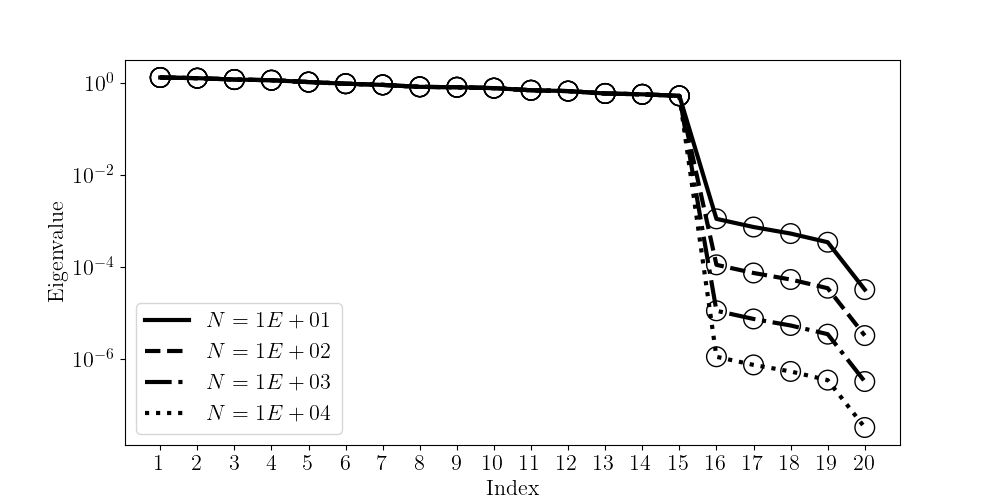

In [41]:
run_wme_covariance_example(close_fig=False)

# Higher-Dimensional Linear Gaussian Examples

This notebook is intended to supplement [ref] section 4 on numerical comparisons of MUD, MAP, and Least Squares solutions to the Linear Gaussian problem as the dimension of the problem increases. 


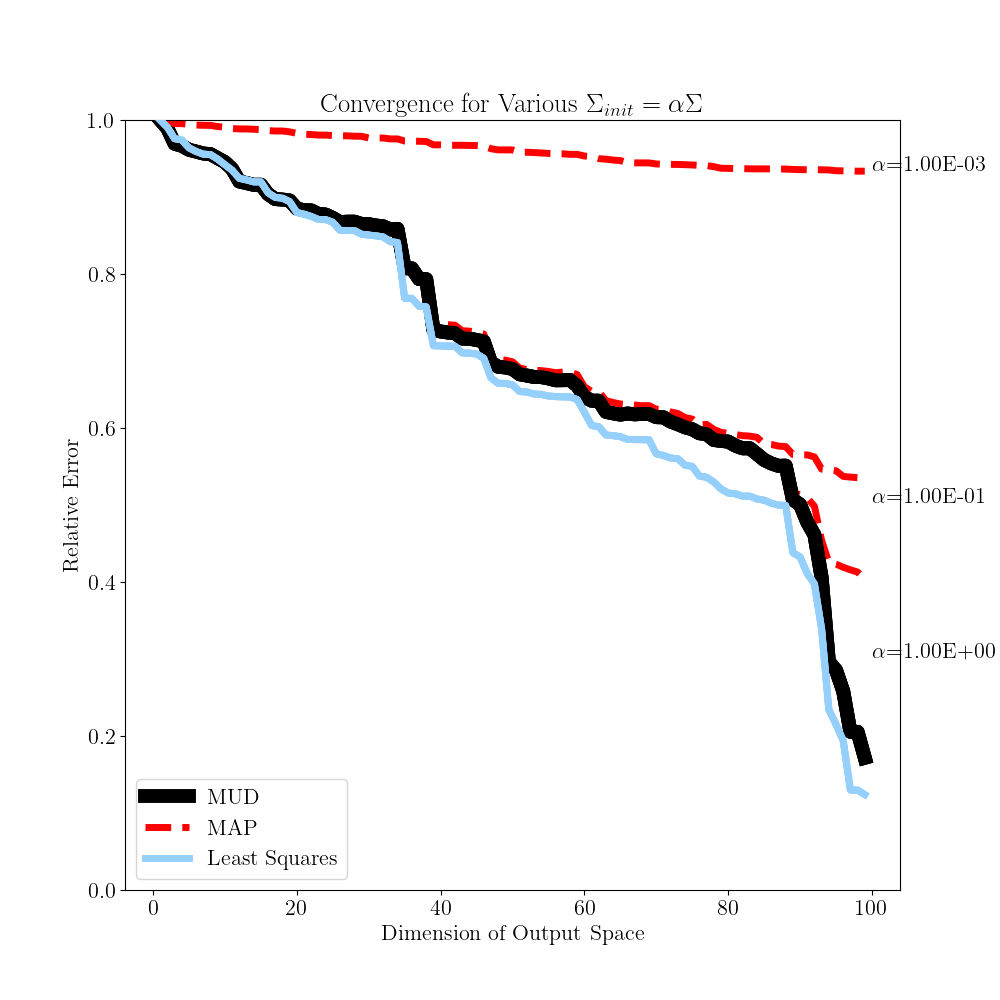

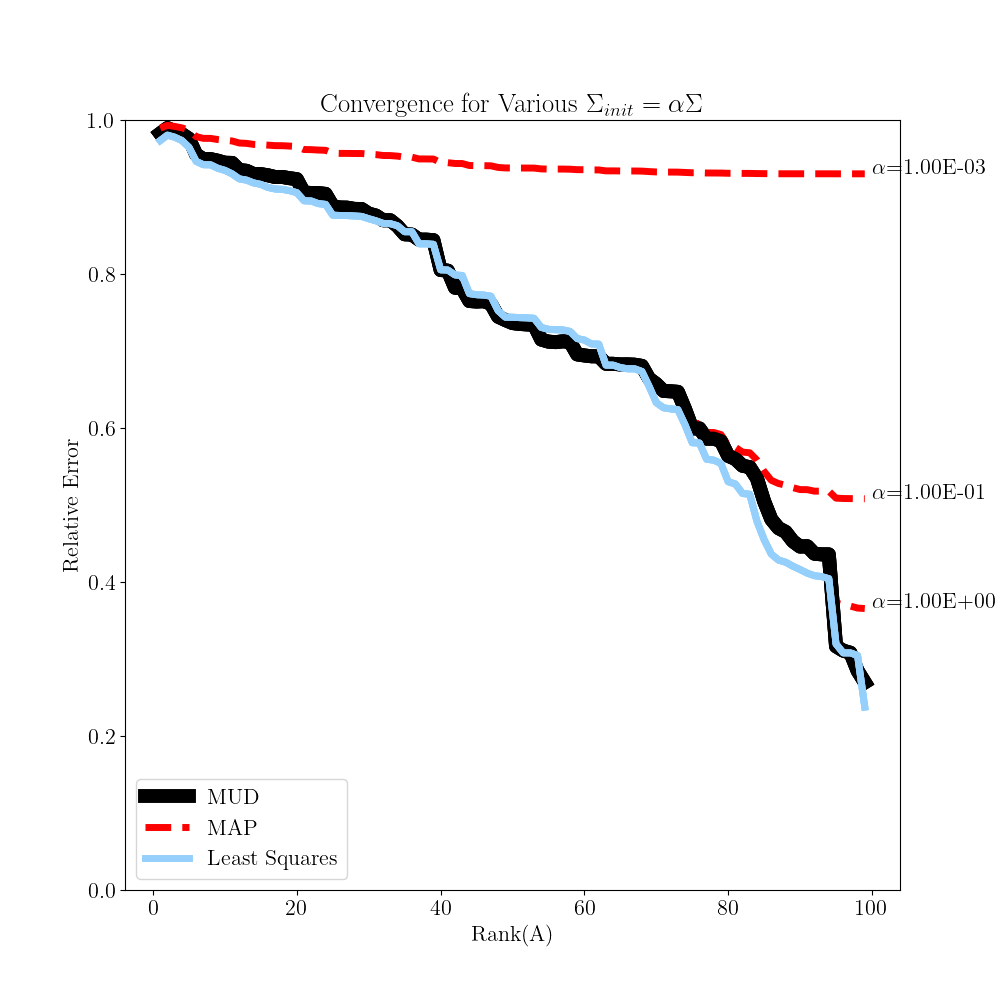

In [42]:
run_high_dim_linear(close_fig=False)

# Data-Constructed QoI Maps II: Data Clouds and Principle Component Analysis

This notebook is intended to supplement [ref] section 6 where data-constructed Quantity of Interest (QoI) Maps are explored.

# Spatial and Temporal Data Examples

The Weighted Mean Error Map in section 3 (ref equation) was introduced as a way to incorporate data into the parameter identification problem in order to reduce the variance as more data is incorporated, with corollary (ex) showing how, in the linear gaussian case, we were guaranteed to reach a unique MUD point after incorporating enough data. Furthermore in example [ref] we saw how, for a simple non-linear map $Q(\lambda) = \lambda^5$, we were able to incorporate repeated measurements into the $Q_{WME}$ map to effectively reduce variance in our MUD estimate as more data was incorporated. 

The question now becomes, how do we incorporate data into the the WME map when the data collected is not from repeated measurements - that is we have multiple sensors collecting data over a spatial and/or time domain, such that correlations exist between measurements taken? The construction of the WME map was based off the argument of statistical sufficiency with the assumptions of a repeated measurement case, taking an equally weighted average of the residuals since they are assumed to be uncorrelated. It is unlikely that this equal waiting will be the most efficient way of encoding the variability in the observed data in the general spatio-temporal measurement case. Consider an exponential decay system, where the uncertain parameter is the initial quantity of material being present. It is intuitive enough that data from initial time-steps of the system as opposed to data from time-steps when there is very little material left, will be the most important to determining the initial condition of the system. Thus we need a way of decorrelating the data cloud of spatio-temporal data to extract the maximum variability in the data set when constructing the $Q$ map based off of residuals. 

For  this we turn to the ubiquitous and popular Principal Component Analysis PCA. Introduced first by [Pearson and Hotelling refs], Principal Component Analysis, or PCA, is a way to reduce dimensionality of a large set of correlated data by transforming the data into a new set of variables known as Principal Components, which are uncorrelated and which, when ordered, contain the maximum amount of variation in the data per component [re-word this]. The PCA has been used in a wide variety of applications such as _ and is known by many different names, including _. 

Consider now our matrix of coll

TODO: Using truncated PCA. PCA equation and $Q_PCA$ equation. Address how no more $1/\sqrt(N)$ term and now instead $1/||\alpha_i||$ now instead for each principle component. Also note how the $Q_PCA$ map will have as man ycomponents as 

In the following examples we explore how the $Q_{PCA}$ map can effectively incorporate spatio-temporal data for the PIP in the case of two non-linear inversion problems. In both examples the PCA method effectively produces a better $Q$ map to invert leading to better parameter estimates.

## Spatial Data Example: Poisson’s Equation with Uncertain Boundary Condition

We begin by first considering the aggregation of data over a spatial domain. In this problem, the uncertain model parameter is now described by an unknown function defining the boundary data to a stationary PDE.

Consider the Poisson problem:

$$
\begin{cases}
\hfill -\nabla \cdot \nabla u &= f(x), \quad\text{on } x\in \Omega, \\
\hfill u &= 0, \quad\text{ on } \Gamma_T \cup \Gamma_B, \\
\hfill \frac{\partial u}{\partial \mathbf{n}} &= g(x_2), \quad\text{ on } \Gamma_L, \\
\hfill \frac{\partial u}{\partial \mathbf{n}} &= 0, \quad\text{ on } \Gamma_R,
\end{cases}
$$

where $x=(x_1, x_2) \in \Omega = (0,1)^2$ is the spatial domain; $\Gamma_T$, $\Gamma_B$, $\Gamma_L$, and $\Gamma_R$, denote the top, bottom, left, and right boundaries of this domain, respectively, and $\frac{\partial u}{\partial \mathbf{n}}$ denotes the usual outward normal derivative.
The forcing function $f$ is taken to be $10\exp\left ( ||x - 0.5||^2 / 0.02 \right )$.

Here, we assume that $g(x_2)$ is unknown, and the goal is to use noisy data to estimate this unknown boundary data.
In other words, the parameter $\lambda$ now represents an uncertain function.
To generate the noisy data, we use a reference $g(x_2)\propto x_2^2(x_2-1)^5$ with a constant of proportionality chosen to produce a minimum of $-3$ at $x_2=\frac{2}{7}$.
Then, we compute a reference solution using piecewise-linear finite elements on a triangulation of a $36\times36$ mesh.
Random noise is then added to every degree of freedom of this reference solution, and the spatial data are subsequently computed from a fixed set of 100 randomly placed sensors in the subdomain $(0.05, 0.95)^2 \subset \Omega$.
This process is repeated $20$ times to study the subsequent variation in MUD points due to different realizations of noisy data.

To construct a finite-dimensional parameter space describing the initial uncertainty of $g(x_2)$, we first assume that it is known that $g$ is non-positive and bounded below by $-4$.
We further assume that $g$ is smooth enough to be reasonably approximated by a piecewise-linear continuous spline with four knots and that $g(0)=g(1)=0$.
Thus, the uncertainty is described by the values of the splines at the two interior knot points chosen as the equispaced points $1/3$ and $2/3$.
This defines a finite-dimensional parameter space described by $\Lambda = [-4,0]^2$.
We generate $1000$ samples from an initial uniform density on $\Lambda$ to (1) generate random spline functions and compute the (noise-free) data from solutions associated with these splines; and (2) estimate the push-forward and updated densities along with the MUD estimate of $g(x_2)$.
These same $1000$ samples are used across all $20$ realizations of random noisy data.

### Load Dataset

Rename for clarity as we port it from mud-examples to mud.

In [67]:
fname = Path.cwd() / f"../data/ref_1000_2u.pkl"
with open(fname, "rb") as fp:
    data = pickle.load(fp)
data.keys()

prob_data_file = Path.cwd() / "poisson_prob"
prob = {
    "lam": data["lam"],
    "domain": np.array([[-4, 0], [-4, 0]]),
    "data": data["qoi"],
    "true_vals": data["data"],
    "sensors": data["sensors"],
    "g": data["plot_g"],
    "u": data["plot_u"],
    "sensors": data["sensors"],
}
with open(prob_data_file, "wb") as fp:
    pickle.dump(prob, fp)

In [4]:
raw_data, poisson_prob = load_poisson_prob("poisson_prob", std_dev=0.05, seed=11)

### Solution Surface 

Lets visualize the solution response surface from our reference solution for the true $g(x_2)$, along with the 500 sensors we will be using.

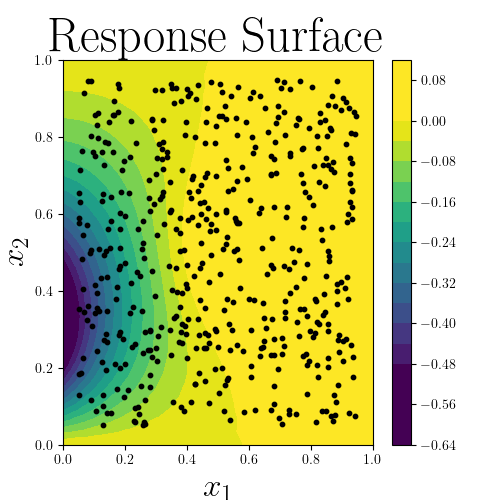

In [5]:
figs = poisson_solution_surface(raw_data, figsize=(9, 9), figs=figs)

### Solving Inverse Problem

Example of how to load and solve the problem.

First we start by creating a `SpatioTemporalProblem` object.

### Baseline Solution - Using $Q_{WME}$

Build a `DensityProblem` object by calling `mud_problem` method. Note by default the $Q_{WME}$ method is used.

We call the `estimate` method to get the mud point estimate

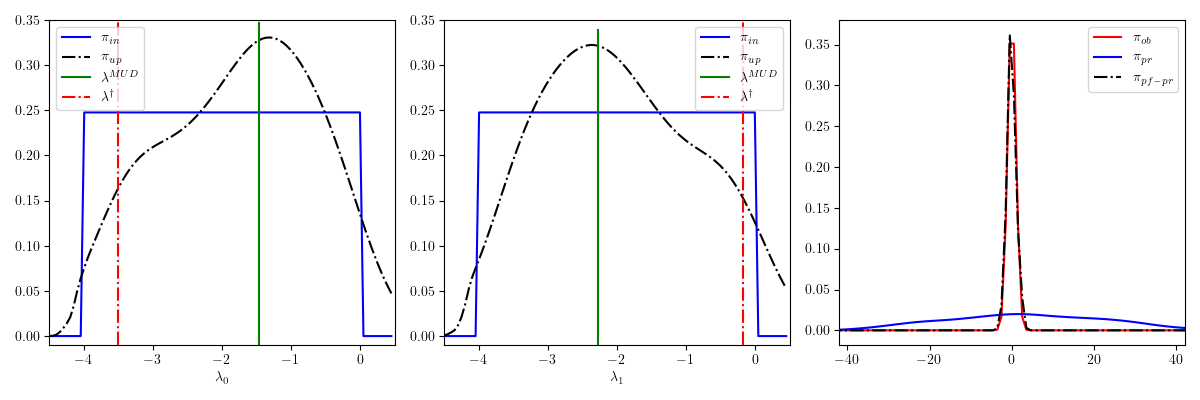

In [6]:
figs = poisson_wme_solution(poisson_prob, figs=figs)

### PCA Solution

Now lets try to solve using the $Q_{PCA}$ map.

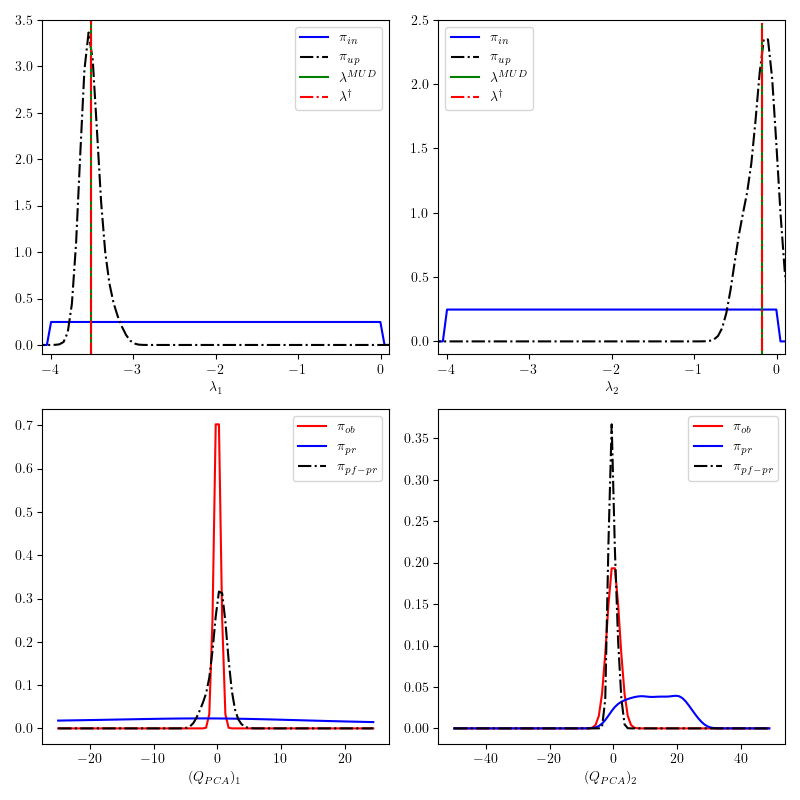

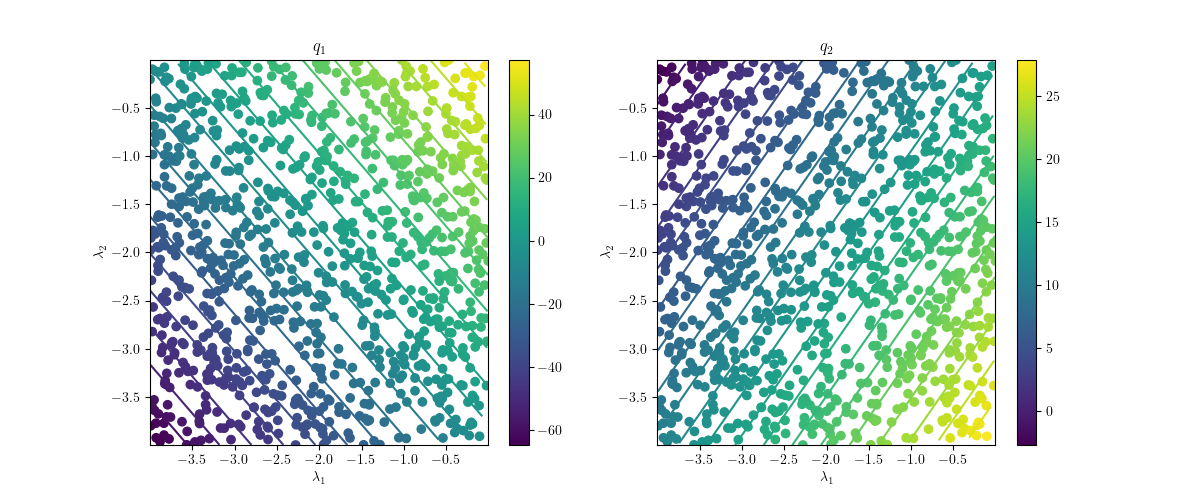

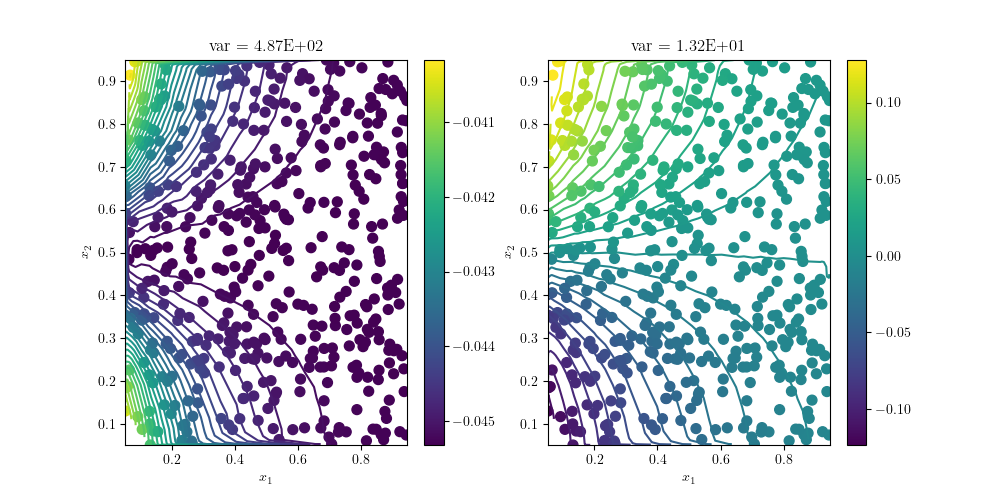

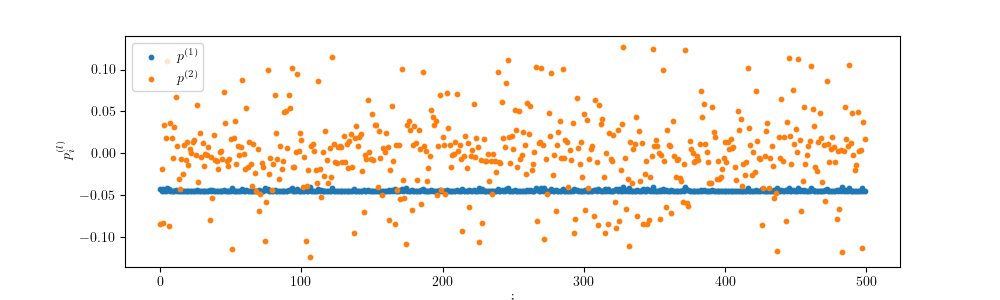

In [7]:
figs = poisson_pca_solution(poisson_prob, figs=figs)

Notes about pca component vector plot for poisson problem:
 - First component seems to be an equal weighting of all points, similar to $Q_{WME}$
 - Second component seems to have a large band of values near zero. 
 
 TODO: Investigate band of values near zero for second component. Plot those that are within $0.0 \pm 0.01$ and see where they are located on the grid. Probably on the edges where not much variability in the data.

### Solution Plots 

Plots of the solution splines approximating $g(x_2)$.

Generates figures for g(x_2) for initial samples plot

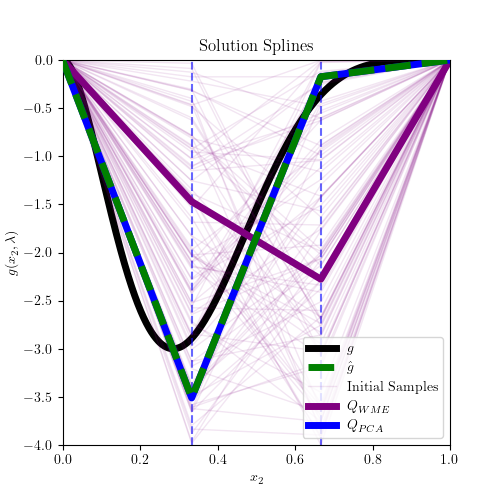

In [8]:
figs = poisson_g_initial_plot(poisson_prob, data=raw_data, figs=figs)

### Variance Reduction - Increasing number of sensors

For this particular example, the number of sensors used over the response surface space to collect data will be varied. Configurations for how this experiment is set up and run are as follows:

* Data-set used:
    * Compute $s = 1000$ samples from a uniform distribution over the parameter space $\Lambda - [-4, 0]^2$.
    * Solutions computed using piecewise-linear finite elements on a triangulation of a $36\times36$ mesh (using fenics library).
    * Data collected from solutions at 500 randomly located sensors over subdomain $(0.05, 0.095)^2 \subset \Omega$.
    * Solution for each $\lambda$ sample is saved in the ``data`` field 
    * Reference solution for true $g(x_2)$ is in ``true_vals`` field.
    * ``sensors`` field contains the locations of the sensors.
* For the trials we:
    * Randomly pick 400 of these 500 sensors.
    * Perform epochs where we pick the first $n = \{[2, 5, 10, 20, 50, 100, 200, 400]\}$ sensors from the list of 400 to solve the inverse problem.
    * For each epoch $n$, run 20 independent trials, each trial representing a different realizations of random noisy data.
        * Adding $\mathcal{N}(0,0.05)$ noise to the reference solution at each sensor location for each trial.
        * After adding noise to a reference solution, find which 
* Record for each trial:
    1. Diagnostic $\mathbb{E}(R), R = \frac{\pi_{ob}(Q(\lambda))}{\pi_{pr}(Q(\lambda))}$
    2. MUD point using $Q_{WME}$ - $\lambda^*_{WME}$.
    3. MUD point using $Q_{PCA}$ map with 2 components - $\lambda^*_{PCA}$.
    4. #TODO: MAP Point

In [14]:
sensors = [2, 5, 10, 20, 50, 100, 200, 400]
probs, info = poisson_run_trials(str(Path.cwd() / "poisson_prob"), sensors=sensors)
info

type    n   i     lam_1     lam_2       err     exp_r
0    wme    2   0 -0.042403 -0.064931  3.551303  0.071740
1    pca    2   0 -3.971922 -0.097644  0.383147  0.100901
2    map    2   0 -3.593596 -0.037054  0.000000       NaN
3    wme    2   1 -0.042403 -0.064931  1.493925  0.071618
4    pca    2   1 -0.042403 -0.064931  1.493925  0.088030
..   ...  ...  ..       ...       ...       ...       ...
475  pca  400  18 -3.334819 -0.428115  0.141513  0.770382
476  map  400  18 -3.194505 -0.446502  0.000000       NaN
477  wme  400  19 -0.736074 -2.960294  3.467796  1.007712
478  pca  400  19 -2.906822 -0.760034  0.376992  0.770508
479  map  400  19 -3.167685 -0.487871  0.000000       NaN

[480 rows x 7 columns]

In [15]:
# Save Poisson Trials Data that was used for plots
info.to_csv("poisson_trials.csv")

In [16]:
info = pd.read_csv("poisson_trials.csv")

In [1]:
figname = "pca_qoi"
if figname in figs.keys():
    plt.close(figs[figname].number)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

idx = 0
to_plot = [2, 5, 20, 200, 400]
for ns in sensors:
    if ns in to_plot:
        # probs[idx][0][0].plot_qoi(ax=ax, s=1, color='r')
        probs[idx][0][1].plot_qoi(ax=ax, s=1, label=f"$n = {ns}$", zorder=-ns)
        # probs[idx][0][2].plot_qoi(ax=ax, s=1, color='b')
    idx += 1

ax.set_xlabel("$(Q_{PCA})_1$")
ax.set_ylabel("$(Q_{PCA})_2$")
ax.set_ylim([-10, 30])
ax.legend()

figs[figname] = plt.gcf()

NameError: name 'figs' is not defined

In [18]:
def plot_conv(
    info, method="pca", field="err", agg="mean", ax=None, fit=False, **kwargs
):

    stat = info.groupby(["type", "n"])[field].aggregate([agg])
    stat = stat.unstack(level=0)[(agg, method)]

    if ax is None:
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(1, 1, 1)

    # Plot pca errors
    ax.plot(sensors, stat.values, "*", zorder=10, **kwargs)

    # Plot best fit exponential through pca errs
    if fit:
        slope, intercept = np.polyfit(np.log(stat.index), np.log(stat.values), 1)
        ax.plot(
            stat.index,
            np.exp(intercept) * np.power(np.array(sensors), slope),
            label=f"{method} slope = {slope:0.3}",
            **kwargs,
        )
        ax.set_xscale("log")
        ax.set_yscale("log")

    ax.set_xlabel("Number of sensors")

    if field == "err" and agg == "mean":
        ax.set_title("$\mathbb{E}(|\lambda_{MUD} - \lambda^\dagger|)$")
    if field == "err" and agg == "var":
        ax.set_title("Var$(|\lambda_{MUD} - \lambda^\dagger|)$")
    if field == "exp_r" and agg == "mean":
        ax.set_title("$\mathbb{E}(R)$")
    if field == "exp_r" and agg == "var":
        ax.set_title("Var$(R)$")

    ax.legend()

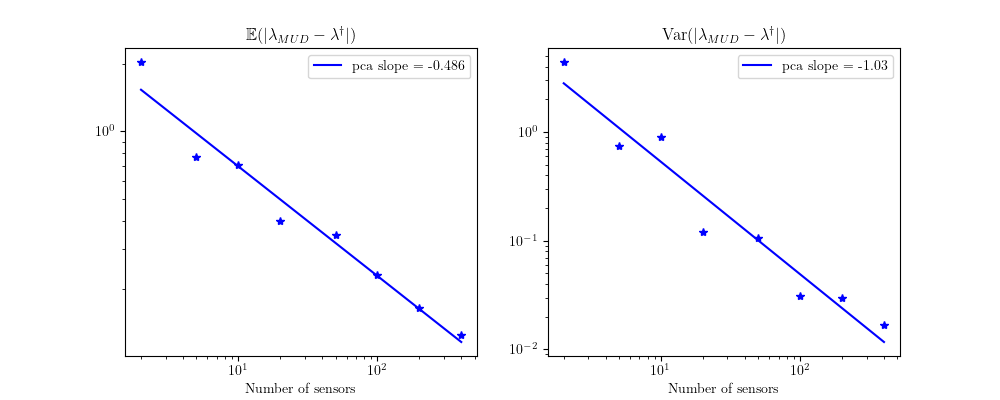

In [21]:
figs = {}
figname = "pca_err"
if figname in figs.keys():
    plt.close(figs[figname].number)

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1)

plot_conv(info, method="pca", field="err", agg="mean", ax=ax, fit=True, color="b")
# plot_conv(info, method="wme", field="err", agg="mean", ax=ax, fit=True, color="orange")

ax = fig.add_subplot(1, 2, 2)

plot_conv(info, method="pca", field="err", agg="var", ax=ax, fit=True, color="b")
# plot_conv(info, method="wme", field="err", agg="var", ax=ax, fit=True, color="orange")

figs[figname] = fig

{'poisson_g_variance_pca': <Figure size 500x500 with 1 Axes>}

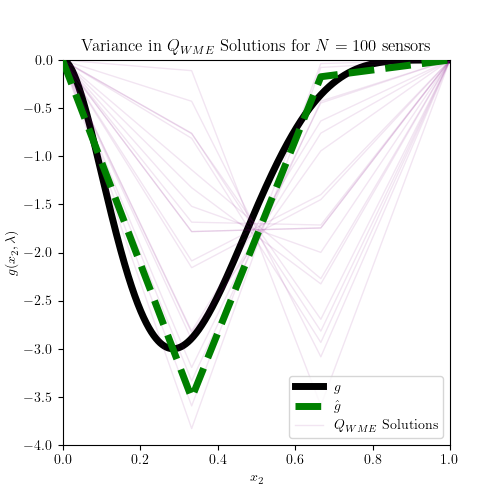

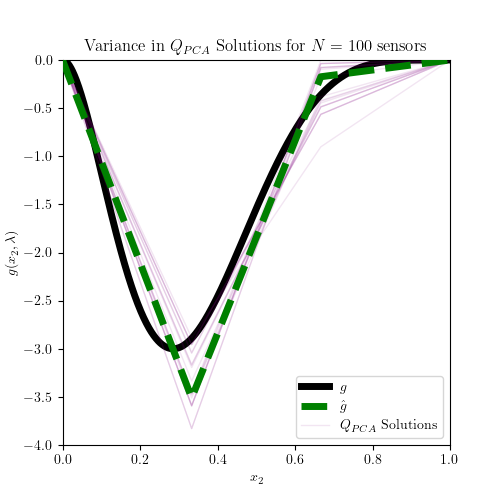

In [20]:
poisson_g_plot_variance_wme(info, n=100)
poisson_g_plot_variance_pca(info, n=100)

### Comparison Plots

Here we explore using sns for bivariate joint plots to compare solutions to inverse problem.

In [16]:
def sns_kde_joint_plot(x, y, weights=None):
    """Wrapper around sns joint plot"""
    g = sns.JointGrid(ratio=2)

    sns.kdeplot(x=x, y=y, ax=g.ax_joint, weights=z)
    sns.kdeplot(x=x, ax=g.ax_marg_x, weights=z)
    sns.kdeplot(y=y, ax=g.ax_marg_y, weights=z)

    return g

## Temporal Data Example: ADCIRC with Uncertain Wind Drag